# Pear Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). 

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
print('Installation ')

torch:  1.12 ; cuda:  cu116
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu116/torch1.12/index.html
Installation 


## Setup

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
!unzip Pears.zip
!ls

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [4]:
from detectron2.data.datasets import register_coco_instances

for d in ["train", "test"]:
    register_coco_instances(f"Pears_{d}", {}, f"Pears/{d}.json", f"Pears/{d}")

WARNING [08/11 22:31:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/11 22:31:01 d2.data.datasets.coco]: Loaded 79 images in COCO format from MultiPeer4/train.json


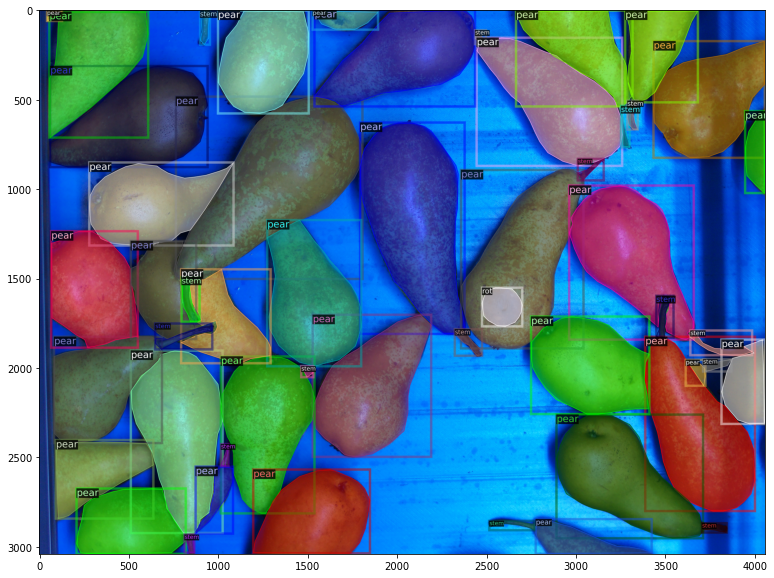

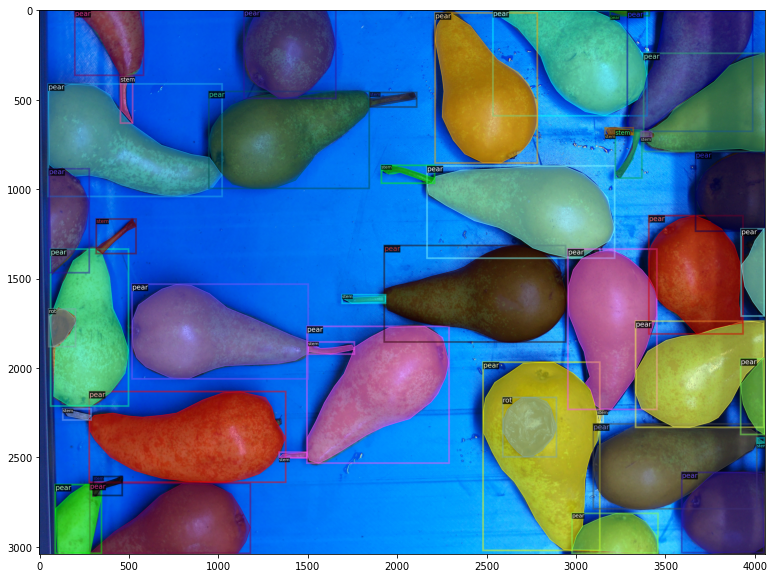

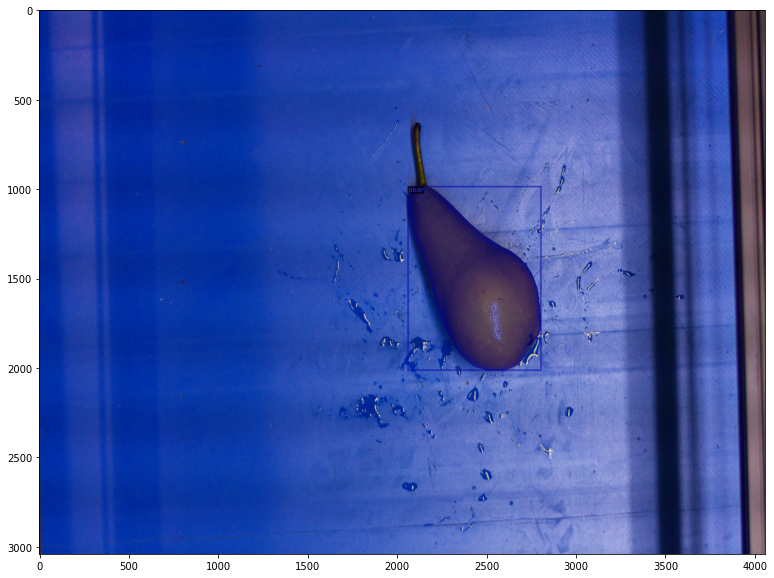

In [5]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("Pears_train")
peer_metadata = MetadataCatalog.get("Pears_train")

for d in random.sample(dataset_dicts, 3):
    #print('afbeelding d', d)

    seg_array = d['annotations'][0]['segmentation'][0]
    #print(seg_array)
    re_array = []
    #print(len(seg_array))
    for i in range(len(seg_array)):
        #print(seg_array[i])
        if i % 2 == 0:
            re_array.extend([float((seg_array[i]) *1.00 )- 0])
        else:
            re_array.extend([float((seg_array[i]) *1.00 )+ 0])

        
    #re_array = re_array.reverse()
    #print('re_array', re_array)

    d['annotations'][0]['segmentation'][0] = re_array

    img = cv2.imread(d["file_name"])
    v = Visualizer(img, metadata=peer_metadata, scale=1.0)
    v = v.draw_dataset_dict(d)
    print(v)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Pears_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/11 17:15:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[08/11 17:15:57 d2.engine.train_loop]: Starting training from iteration 0


/home/altss1xmq39dxmqy44n54c/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/11 17:16:21 d2.utils.events]:  eta: 0:34:13  iter: 19  total_loss: 2.047  loss_cls: 1.143  loss_box_reg: 0.1633  loss_mask: 0.6956  loss_rpn_cls: 0.0299  loss_rpn_loc: 0.008302  time: 0.5105  data_time: 0.0771  lr: 4.9953e-06  max_mem: 2336M
[08/11 17:16:32 d2.utils.events]:  eta: 0:34:03  iter: 39  total_loss: 2.438  loss_cls: 1.01  loss_box_reg: 0.3151  loss_mask: 0.6761  loss_rpn_cls: 0.3671  loss_rpn_loc: 0.0464  time: 0.5137  data_time: 0.0044  lr: 9.9902e-06  max_mem: 2484M
[08/11 17:16:41 d2.utils.events]:  eta: 0:33:06  iter: 59  total_loss: 1.509  loss_cls: 0.7019  loss_box_reg: 0.1558  loss_mask: 0.622  loss_rpn_cls: 0.02639  loss_rpn_loc: 0.005886  time: 0.5062  data_time: 0.0040  lr: 1.4985e-05  max_mem: 2484M
[08/11 17:16:52 d2.utils.events]:  eta: 0:32:57  iter: 79  total_loss: 2.179  loss_cls: 0.5608  loss_box_reg: 0.4316  loss_mask: 0.5847  loss_rpn_cls: 0.4541  loss_rpn_loc: 0.09322  time: 0.5107  data_time: 0.0045  lr: 1.998e-05  max_mem: 2484M
[08/11 17:17:02 d2.

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("Pears_test", )
predictor = DefaultPredictor(cfg)

[08/11 17:49:36 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

WARNING [08/11 17:50:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/11 17:50:04 d2.data.datasets.coco]: Loaded 21 images in COCO format from MultiPeer4/test.json
filename:  output_MultiPeer4/test/1658907450321_25.jpg.jpg


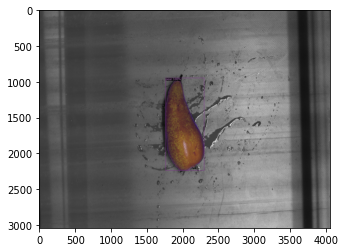

filename:  output_MultiPeer4/test/1660043323611.jpg.jpg


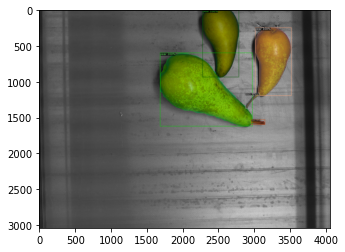

filename:  output_MultiPeer4/test/1660038243125.jpg.jpg


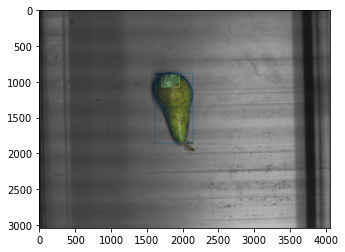

In [10]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("Pears_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=peer_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    print('filename: ', 'output_' + d["file_name"] + '.jpg')
    cv2.imwrite(d["file_name"].replace('.jpg', '_output.jpg') ,cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()